# Neurons and Multi-Layer Perceptrons (MLPs)

Using the previously defined `Value` class, we can define a `Neuron` class.

In [124]:
import math
import random

In [125]:
class Value:
    """Class that represents a value that can be differentiated in respect to other values.

    Attributes:
        data: The value itself.
        _prev: A set of values that this value is dependent on.
        _op: The operation that produced this value.
    """

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # derivative of the loss function in respect to this value
        self._backward = lambda: None # defines how to propagate the output gradient to the input gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        def _backward():
            print(f'backward for {self} and {other}')
            # For addition, the local derivative is always 1. So, given the expression a = b + c, it follows from the chain rule 
            # dz/dx = dz/dy*dy/dx that the gradients of b and c are (1.0 * the gradient of a)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        if isinstance(other, Value):
            out = Value(self.data + other.data, (self, other), '+')
            out._backward = _backward
            return out
        else:
            out = Value(self.data + other, (self,), '+')
            out._backward = _backward
            return out
        
    def __radd__(self, other):
        return self + other
        
    def __neg__(self): #-self
        return self * -1
        
    def __sub__(self, other): #self - other, uses __neg__ and __add__
        return self + (-other)
        
    def __mul__(self, other):
        def _backward():
            # For multiplication, the local derivative is always the other value (because for z=x*y, dz/dx = y). 
            # So, given the expression a = b * c, it follows from the chain rule that the gradient of b
            # is (c * the gradient of a), and the gradient of c is (b * the gradient of a).
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        if isinstance(other, Value):
            out = Value(self.data * other.data, (self, other), '*')
            out._backward = _backward
            return out
        else:
            out = Value(self.data * other, (self,), '*')
            out._backward = _backward
            return out
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    
    def __truediv__(self, other):
        return self * (other ** -1)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad # because d/dx e^x = e^x
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

Using the `Value` class, we can now define the class `Neuron` to represent a single artificial neoron:

In [126]:
class Neuron:
    """Implementation of a neuron in a neural network."""

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # compute raw activation w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out



We can test the `Neuron` class like this:

In [127]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

x = [4.0, 5.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.9991969226599986, label=),
 Value(data=-0.9999905177611398, label=),
 Value(data=-0.2778010760585038, label=)]

Now, with the `Neuron` class in place, we can define the class `Layer` to represent a layer of neurons:

In [128]:
class Layer:
    """Implementation of a layer in a neural network."""

    def __init__(self, nin, nout):
        """Initialize a layer of nout neurons, each taking nin inputs."""
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

Finally, we can define an MLP:

In [129]:
class MLP:
    """Implementation of a multilayer perceptron."""

    def __init__(self, nin, nouts):
        """Initialize a MLP with nouts layers, each taking nin inputs.

        Args:
            nin: Number of inputs to the MLP.
            nouts: List of number of neurons in each layer (including the output layer).
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

And with that we can create an MLP that has 3 inputs, to hidden layers with 4 neurons each, and 1 output:

In [130]:
x = [2.0, 3.0, 1.0]
m = MLP(3, [4, 4, 1])
m(x)

Value(data=-0.2658255717428615, label=)

And draw the graph of the MLP:

In [131]:
# Code for visualizing the graph
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle node for it ('record')
        dot.node(name = uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            # if the value was produced by an operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)

    return dot

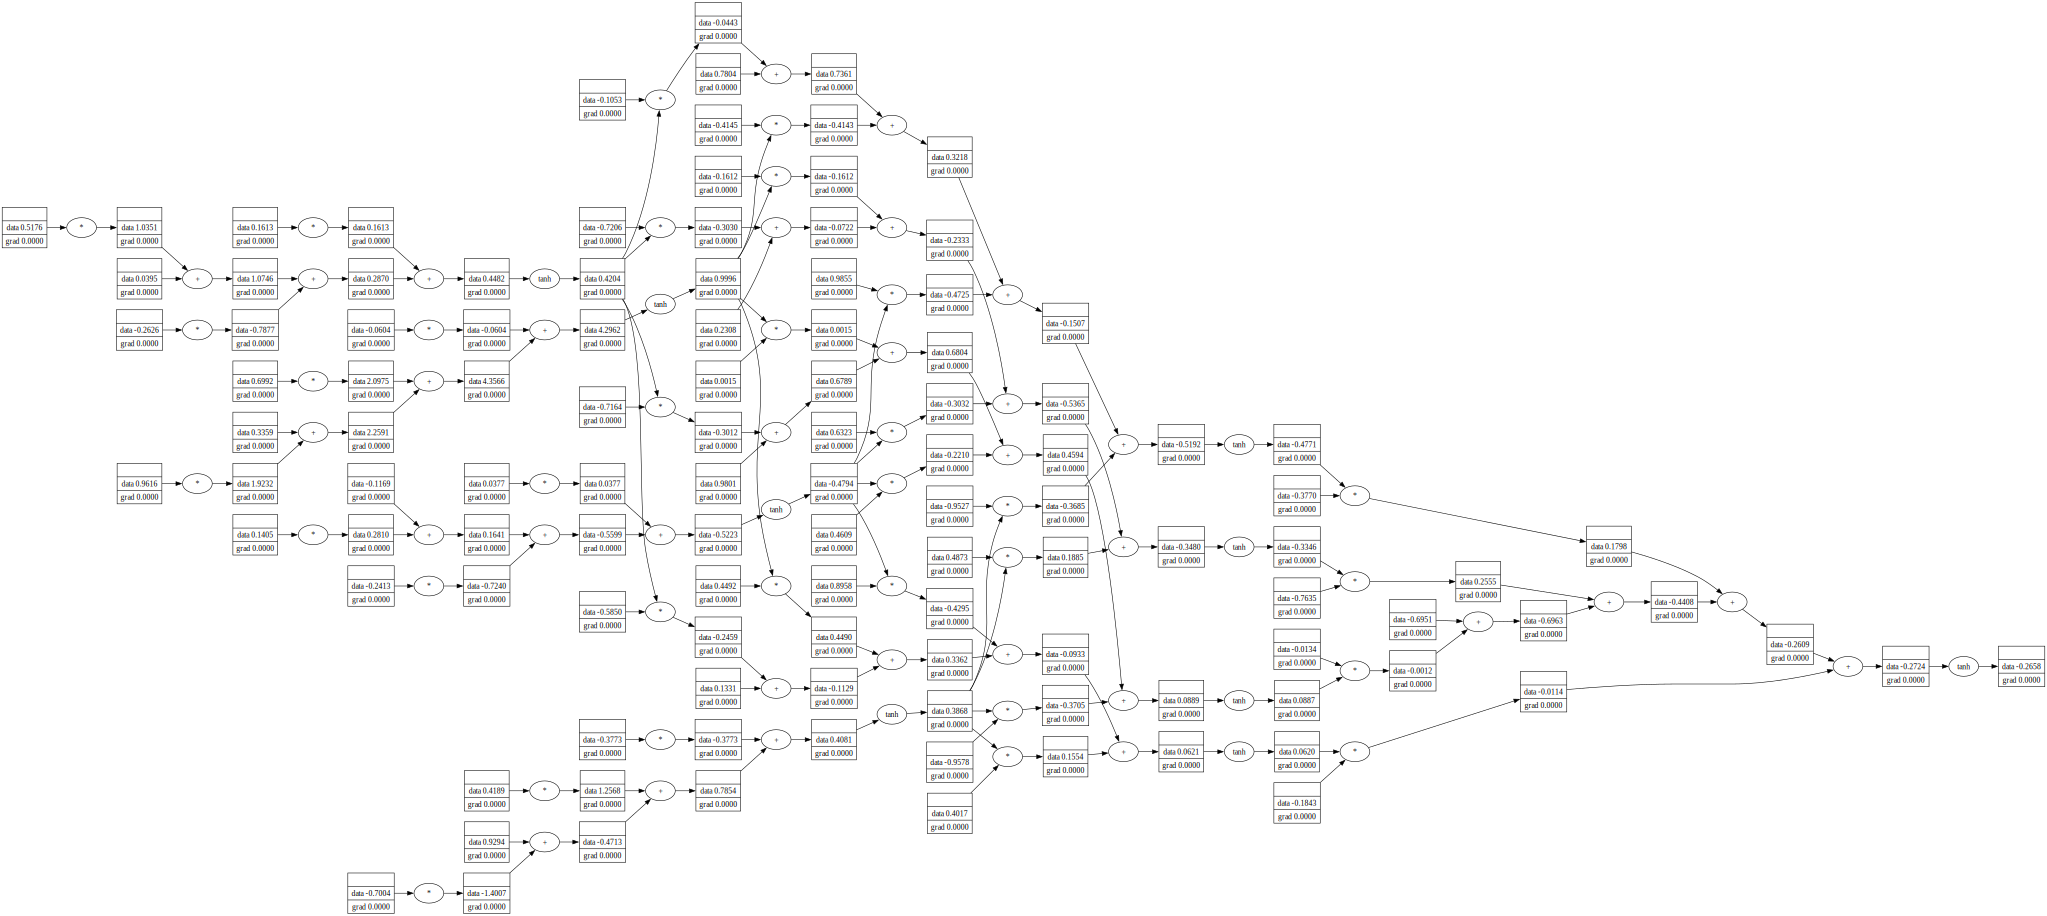

In [132]:
draw_dot(m(x))

We can now perform backpropagation using micrograd.

In [167]:
# Simple dataset
# Inputs
xs = [
    [1.2, 3.5, -1.6],
    [3.0, -4.0, 0.5],
    [0.5, 3.0, 5.0],
    [7.0, 6.0, -3.0],
]

# Target outputs
ys = [2.42, -2.43, -2.44, 2.45]

# What predictions does the model currently make?
ypred = [m(x) for x in xs]
ypred

[Value(data=-0.6676110183738908, label=),
 Value(data=-0.6348421015633672, label=),
 Value(data=-0.27271233694395813, label=),
 Value(data=0.02962480818810651, label=)]

To train the MLP, we need a single number to measure its performance and this number is called a _loss_. We will define loss in such a way so we can minimize it. Specifically, we will define it as the mean square error loss:

$$\sum_i (y_i - gt_i)^2$$

where $y_i$ is the MLP's actual output for input vector $i$ and $gt_i$ is the ground truth for input vector $i$. For instance, in our case, $gt_0 = 1.0$.

In [170]:
loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
print(type(loss))
loss
#draw_dot(loss)

<class '__main__.Value'>


Value(data=23.311285564676666, label=)

In [173]:
# let's run backpropagation ...
loss.backward()

# ... and see how the gradients look like
n.layers[0].neurons[0].w[0].grad


backward for Value(data=17.453069495538205, label=) and Value(data=5.858216069138462, label=)
backward for Value(data=0.02962480818810651, label=) and -2.45


AttributeError: 'float' object has no attribute 'grad'